# Show data about locally built blocks
See .env.example to set the environment variables.

In [21]:
!pip install jupysql clickhouse_sqlalchemy matplotlib pandas python-dotenv seaborn > /dev/null 2>&1

In [8]:
import dotenv
import os

dotenv.load_dotenv()
network = os.getenv('NETWORK')
print(f"network: {network}")

network: mainnet


In [9]:
# Connect to ClickHouse
import os
from sqlalchemy import create_engine

username = os.getenv('XATU_CLICKHOUSE_USERNAME')
password = os.getenv('XATU_CLICKHOUSE_PASSWORD')
host = os.getenv('XATU_CLICKHOUSE_HOST')

print(f"username: {username}")
print(f"host: {host}")

db_url = f"clickhouse+http://{username}:{password}@{host}:443/default?protocol=https"
engine = create_engine(db_url)
connection = engine.connect()

username: pandaops
host: clickhouse.xatu.ethpandaops.io


In [10]:
from sqlalchemy import text
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np

# Define the filtering time range
start_date = '2024-11-28 00:00:00'
end_date = '2024-11-29 00:00:00'

print(f"Filtering results between {start_date} and {end_date} on {network}")

Filtering results between 2024-11-28 00:00:00 and 2024-11-29 00:00:00 on mainnet


In [11]:
# Query for MEV proposer payload data
proposer_query = text("""
SELECT
    slot,
    block_hash
FROM
    mev_relay_proposer_payload_delivered
WHERE
    slot_start_date_time >= :start_date
    AND slot_start_date_time < :end_date
    AND meta_network_name = :network
""")
proposer_result = pd.read_sql(proposer_query, connection, params={"start_date": start_date, "end_date": end_date, "network": network})


In [12]:
# Query MEV relay bids
mev_query = text("""
SELECT DISTINCT
    slot,
    block_hash,
    value AS mev_execution_payload_reward
FROM
    mev_relay_bid_trace
WHERE 
    slot_start_date_time >= :start_date
    AND slot_start_date_time < :end_date
    AND meta_network_name = :network
""")
bid_result = pd.read_sql(mev_query, connection, params={"start_date": start_date, "end_date": end_date, "network": network})


In [13]:
# Query locally built blocks
local_query = text("""
SELECT
    slot,
    MAX(execution_payload_value) AS local_execution_payload_reward
FROM
    beacon_api_eth_v3_validator_block
WHERE
    slot_start_date_time >= :start_date
    AND slot_start_date_time < :end_date
    AND meta_network_name = :network
GROUP BY
    slot
ORDER BY
    slot
""")
local_data = pd.read_sql(local_query, connection, params={"start_date": start_date, "end_date": end_date, "network": network})


In [14]:
# Massage our data a little bit.
#
# First, get the maximum bid value for each slot/block_hash combination
# Only needed if DISTINCT is not used in the mev_query.
# bid_result_max = bid_result.groupby(['slot', 'block_hash'])['mev_execution_payload_reward'].max().reset_index()

# Then merge proposer data with the max MEV relay bids using INNER join
mev_df = pd.merge(proposer_result, bid_result, on=["slot", "block_hash"], how="inner")

# Group by slot to ensure we only have one record per slot
mev_df_unique = mev_df.groupby('slot').agg({
    'block_hash': 'first',
    'mev_execution_payload_reward': 'max'
}).reset_index()

# Then merge with local build data using slot
comparison_df = pd.merge(mev_df_unique, local_data, on="slot", how="outer")

# Fill missing values with 0 and convert to float
comparison_df["mev_execution_payload_reward"] = comparison_df["mev_execution_payload_reward"].fillna(0)
comparison_df["local_execution_payload_reward"] = comparison_df["local_execution_payload_reward"].fillna(0)

<Figure size 1400x800 with 0 Axes>

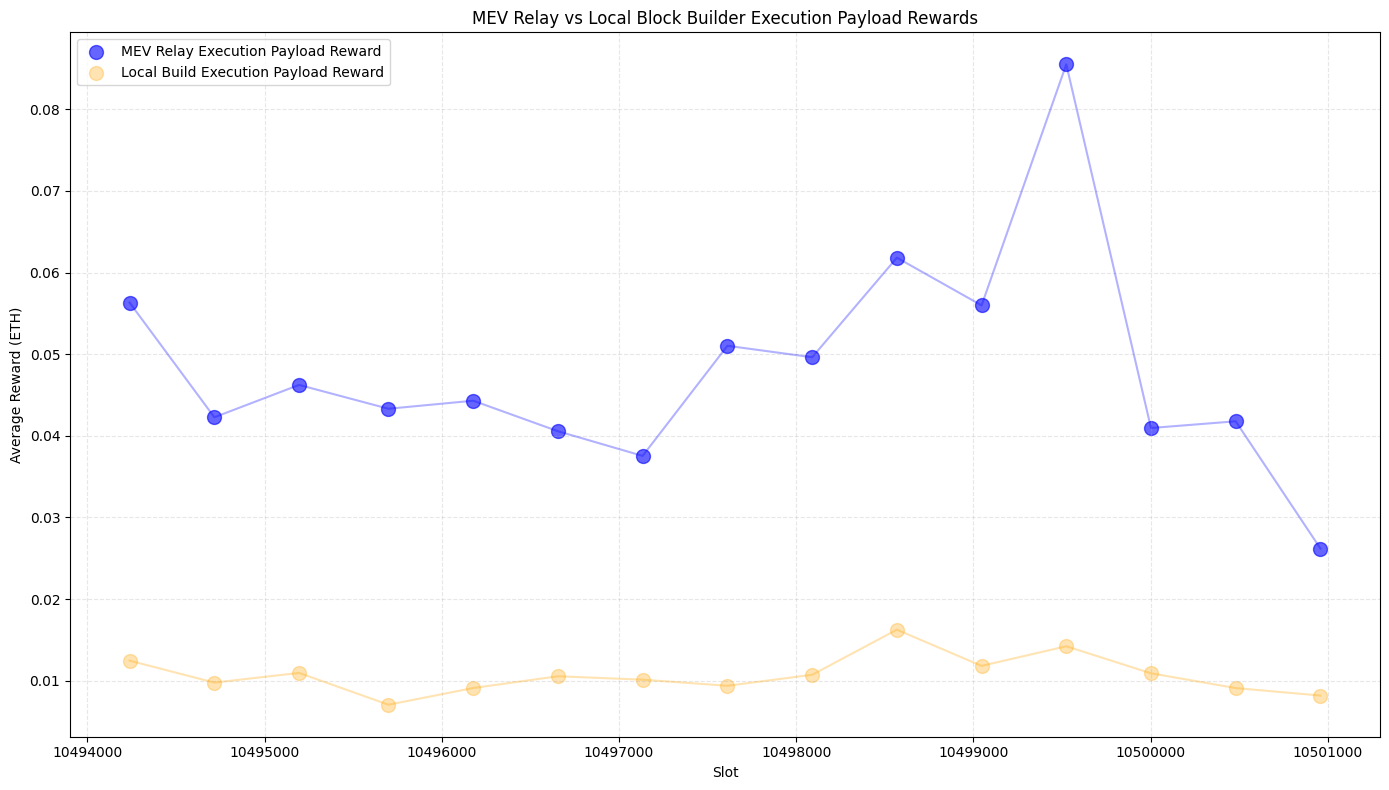

In [15]:
# Create scatter plot
plt.figure(figsize=(14, 8))

# Create 15 buckets based on slot ranges
comparison_df['slot_bucket'] = pd.qcut(comparison_df['slot'], q=15, labels=False)

# Group by bucket and calculate mean rewards
bucketed_data = comparison_df.groupby('slot_bucket').agg({
    'slot': 'mean',  # Use mean slot as x-axis position
    'mev_execution_payload_reward': 'mean',
    'local_execution_payload_reward': 'mean'
}).reset_index()

# Create scatter plot
plt.figure(figsize=(14, 8))

# Convert Wei to ETH for plotting (divide by 10^18)
plt.scatter(
    bucketed_data["slot"],
    bucketed_data["mev_execution_payload_reward"] / 1e18,
    color="blue",
    label="MEV Relay Execution Payload Reward",
    alpha=0.6,
    s=100  # Made points larger since we have fewer of them
)

plt.scatter(
    bucketed_data["slot"],
    bucketed_data["local_execution_payload_reward"] / 1e18,
    color="orange",
    label="Local Build Execution Payload Reward",
    alpha=0.3,
    s=100
)

# Add lines connecting the points
plt.plot(
    bucketed_data["slot"],
    bucketed_data["mev_execution_payload_reward"] / 1e18,
    color="blue",
    alpha=0.3
)

plt.plot(
    bucketed_data["slot"],
    bucketed_data["local_execution_payload_reward"] / 1e18,
    color="orange",
    alpha=0.3
)

# Customize plot
plt.gca().xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: f"{int(x)}"))
plt.xlabel("Slot")
plt.ylabel("Average Reward (ETH)")
plt.title("MEV Relay vs Local Block Builder Execution Payload Rewards")
plt.legend(loc="upper left")
plt.grid(True, alpha=0.3, linestyle="--")
plt.tight_layout()
plt.show()

<Figure size 1400x800 with 0 Axes>

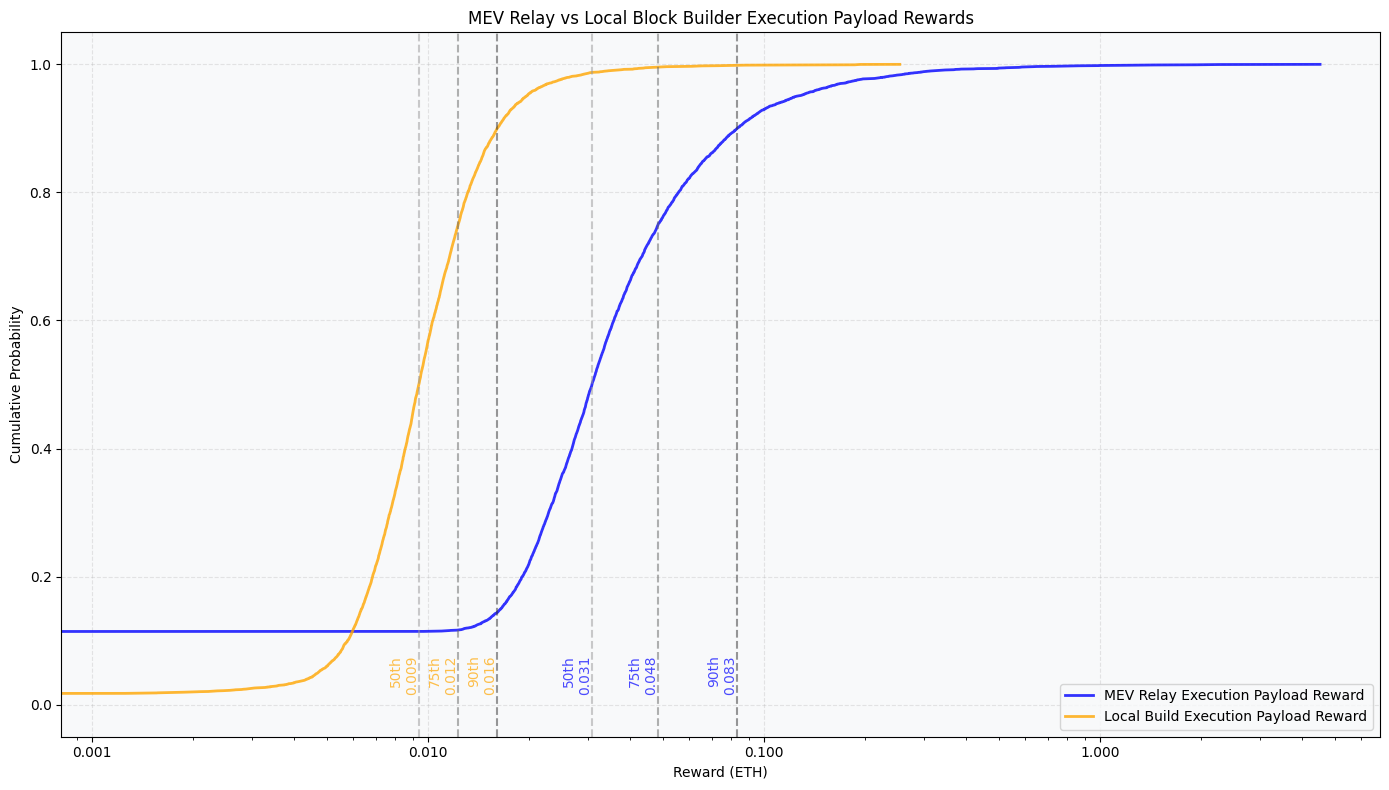

In [25]:
# Create scatter plot
plt.figure(figsize=(14, 8))

# Create 15 buckets based on slot ranges
comparison_df['slot_bucket'] = pd.qcut(comparison_df['slot'], q=15, labels=False)

# Group by bucket and calculate mean rewards
bucketed_data = comparison_df.groupby('slot_bucket').agg({
    'slot': 'mean',  # Use mean slot as x-axis position
    'mev_execution_payload_reward': 'mean',
    'local_execution_payload_reward': 'mean'
}).reset_index()

# ... existing data preparation code ...

# Create CDF plot
plt.figure(figsize=(14, 8))

# Calculate CDFs for both reward types
mev_sorted = np.sort(comparison_df['mev_execution_payload_reward'] / 1e18)
local_sorted = np.sort(comparison_df['local_execution_payload_reward'] / 1e18)
cumulative_prob = np.linspace(0, 1, len(comparison_df))

# Plot CDFs
plt.plot(
    mev_sorted,
    cumulative_prob,
    color="blue",
    label="MEV Relay Execution Payload Reward",
    alpha=0.8,
    linewidth=2
)

plt.plot(
    local_sorted,
    cumulative_prob,
    color="orange",
    label="Local Build Execution Payload Reward",
    alpha=0.8,
    linewidth=2
)

# Add vertical lines for percentiles
percentiles = [50, 75, 90]
colors = ['#999999', '#666666', '#333333']
styles = ['--', '--', '--']

for p, color, style in zip(percentiles, colors, styles):
    mev_p = np.percentile(mev_sorted, p)
    local_p = np.percentile(local_sorted, p)
    
    # Add vertical lines
    plt.axvline(x=mev_p, color=color, linestyle=style, alpha=0.5)
    plt.axvline(x=local_p, color=color, linestyle=style, alpha=0.5)
    
    # Add percentile labels
    plt.text(mev_p, 0.02, f'{p}th\n{mev_p:.3f}', 
             rotation=90, color='blue', alpha=0.7,
             horizontalalignment='right')
    plt.text(local_p, 0.02, f'{p}th\n{local_p:.3f}', 
             rotation=90, color='orange', alpha=0.7,
             horizontalalignment='right')

# Customize plot
plt.xlabel("Reward (ETH)")
plt.ylabel("Cumulative Probability")
plt.title("MEV Relay vs Local Block Builder Execution Payload Rewards")
plt.legend(loc="lower right")
plt.grid(True, alpha=0.3, linestyle="--")
plt.xscale('log')

# Format x-axis to show decimals instead of scientific notation
ax = plt.gca()

ax.xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, p: f'{x:.3f}'))

plt.tight_layout()

plt.show()